## Pressure sensor placement for leakage detection


### Initialize EPANET Python Toolkit (EPyT)

You should always begin with this command to import the toolkit.

[EPyT](https://github.com/OpenWaterAnalytics/EPyT) is available on [PyPI](https://pypi.org/project/epyt/) and can be installed via `pip install epyt`. To upgrade to the latest version if it's already installed, use `pip install --upgrade epyt`.

In [29]:
%pip install epyt pymoo
%pip install numpy==1.23
!git clone https://github.com/Witold21/WDN.git
import os
os.chdir('/content/WDN/EPYT')
!ls

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fatal: destination path 'WDN' already exists and is not an empty directory.
 epyt_epanet_analysis.ipynb		       Walkerton_v1.inp
'epy testy.ipynb'			       Walkerton_v1_temp.inp
 epytflow_leakagedetection.ipynb	       Walkerton_v1_temp.txt
 epyt_leakage_simulation_and_detection.ipynb   Walkerton_v1.txt
 epyt_pressure_sensor_placement.ipynb	       WDN
 REQUIREMENTS.txt


### Download data

In [30]:
from epyt import epanet

import numpy as np

from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Water Network

In [31]:
d=epanet('Walkerton_v1.inp')

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File Walkerton_v1.inp loaded successfully.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Get the number of junctions and nodes
nj = d.getNodeJunctionCount()
nn = d.getNodeCount()
d.printv(nj)
d.printv(nn)

nj = 310
nn = 315


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
reservoir_indices = d.getNodeReservoirIndex()
junction_indices = d.getNodeJunctionIndex()
junction_indices_py = np.array(junction_indices) - 1

d.printv(reservoir_indices)
d.printv(junction_indices_py)

reservoir_indices = [311, 312, 313]
junction_indices_py = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Calculate Sensitivity matrix
[1] Cugueró , M., Puig, V., Quevedo, J. Optimal pressure sensor placement and assessment for leak location using a relaxed isolation index: Application to the Barcelona water network, Control Eng. Pract., vol. 63, pp. 1-12, Jun. 2017.

##### Calculate healthy states in extended time simulation

In [34]:
d.setTimeSimulationDuration(24 * 60 * 60)  # greater weight to low demand hours
d.setTimePatternStart(0)  # in seconds

allParameters = d.getComputedTimeSeries()
P0 = allParameters.Pressure[:, junction_indices_py].T
Dem0 = allParameters.Demand[:, junction_indices_py].T
simSteps = P0.shape[1]

# Create Augmented-time Sensitivity Matrix
# Simulate all leakages and get all scenarios pressures
leak_mag_desir = np.mean(np.mean(Dem0[Dem0 > 0]))
mean_pressure = np.mean(np.mean(P0[P0 > 0]))

leak_emit = leak_mag_desir / np.sqrt(mean_pressure)
emit0 = d.getNodeEmitterCoeff()
S = np.zeros((nj, nj))

for leak in range(1, nj + 1):
    print('Calculating Sensitivity Matrix...')
    print('Simulating leakage', leak, 'out of', nj)
    emit = np.zeros_like(emit0)
    emit[leak - 1] = leak_emit  # set emitter coefficient (leakage) value
    d.setNodeEmitterCoeff(emit)

    allParameters = d.getComputedTimeSeries()

    P = allParameters.Pressure[:, junction_indices_py].T
    Dem = allParameters.Demand[:, junction_indices_py].T
    leak_mag = Dem[leak - 1, :] - Dem0[leak - 1, :]
    Stmp = (P - P0) / leak_mag
    rmax = np.max(np.abs(Stmp), axis=0)
    Stmp = np.abs(Stmp) / rmax
    S[:, leak - 1] = np.max(Stmp, axis=1)

print('Calculations done!')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculating Sensitivity Matrix...
Simulating leakage 1 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 2 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 3 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 4 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 5 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 6 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 7 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 8 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 9 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 10 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 11 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 12 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 13 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 14 out of 310
Calculating Sensitivity Matrix...
Simulating leakage 15 out of 310
Calc

### Place sensors using GA
Select number of sensors to be installed:

In [35]:
sensors_num = 5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Define existing sensors in the network

In [36]:
exist_sens_ind = []; # Define existing sensors in the network
# exist_sens_ind=d.getNodeIndex({'14','63','114','399','572','302','662'});

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Solve using GA: Maximize the minimum sensitivity of all sensors to any leakage

In [37]:
#### Sensor Placement optimization problem - Cost function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Cost function: min sensitivity of all leaks
def GACostFunction(u, S):
    Sm = S[u > 0, :]
    Smax = np.max(Sm, axis=0)
    # cost = 1 - np.min(Smax)-0.1*np.mean(Smax)
    cost = 1-np.min(Smax)
    # cost = 1-np.max(Smax)
    return cost

# Sensor placement optimization problem for a genetic algorithm. It sets up the problem
# dimensions, variable bounds, and defines how to evaluate each solution's fitness using
# the provided cost function (GACostFunction). The genetic algorithm can then use this
# problem definition to evolve sensor placement configurations towards an optimal solution.
class SensorPlacementProblem(Problem):
    def __init__(self, S, nj, sensors_num, exist_sens_ind):
        self.S = S
        self.nj = nj
        self.sensors_num = sensors_num
        self.exist_sens_ind = exist_sens_ind
        super().__init__(n_var=nj, n_obj=1, n_constr=0, xl=0, xu=nj-1, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        f = np.array([GACostFunction(xi, self.S) for xi in x])
        out["F"] = f

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
problem = SensorPlacementProblem(S, nj, sensors_num, exist_sens_ind)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# Configure the Genetic Algorithm (GA)
algorithm = GA(
    n_offsprings=5,
    pop_size=200,  # Population size
    sampling=IntegerRandomSampling(),  # Correctly specified sampling method
    crossover=SimulatedBinaryCrossover(eta=3, prob=1.0),  # Correctly specified crossover method
    # eta determines how closely the offspring are clustered around the parent solutions
    mutation=PolynomialMutation(eta=3, prob=1.0)  # Correctly specified mutation method
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Solve the optimization problem
res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               #  multiple criteria (x_tol for tolerance, n_gen for maximum generations,
               #  and n_last for stall generations - terminates if there is no improvement
               #  in the last 5 generations)
               seed=1,  # The seed=1 is used to ensure reproducibility of results.
               verbose=True)  # flag is included to provide detailed output during the optimization process.
# Extract the result
u = res.X
print(u)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  0.0394276518 |  0.000000E+00
     2 |      205 |  0.0178997689 |  0.000000E+00
     3 |      210 |  0.0023618016 |  0.000000E+00
     4 |      215 |  0.000000E+00 |  0.000000E+00
     5 |      220 |  0.000000E+00 |  0.000000E+00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     6 |      225 |  0.000000E+00 |  0.000000E+00
     7 |      230 |  0.000000E+00 |  0.000000E+00
     8 |      235 |  0.000000E+00 |  0.000000E+00
     9 |      240 |  0.000000E+00 |  0.000000E+00
    10 |      245 |  0.000000E+00 |  0.000000E+00
    11 |      250 |  0.000000E+00 |  0.000000E+00
    12 |      255 |  0.000000E+00 |  0.000000E+00
    13 |      260 |  0.000000E+00 |  0.000000E+00
    14 |      265 |  0.000000E+00 |  0.000000E+00
    15 |      270 |  0.000000E+00 |  0.000000E+00
    16 |      275 |  0.000000E+00 |  0.000000E+00
    17 |      280 |  0.000000E+00 |  0.000000E+00
    18 |      285 |  0.000000E+00 |  0.000000E+00
    19 |      290 |  0.000000E+00 |  0.000000E+00
    20 |      295 |  0.000000E+00 |  0.000000E+00
[ 37  94 287 265  43  27  94 196 116 196  44 102  71  73  66 173 129 202
 132 203  11 211  11 134 118  48  47 164 130 211 184 189 222 296 303 209
  96  75 124  85  85 231 242 222 125  15 178  61 276 183  80  66  54 215
  51 173 179  23 252 262 133 19

/usr/local/lib/python3.10/dist-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
  if hasattr(self, key):
/usr/local/lib/python3.10/dist-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
  v = getattr(self, key)
/usr/local/lib/python3.10/dist-packages/pymoo/core/individual.py:616: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
  if hasattr(self, key):
/usr/local/lib/python3.10/dist-packages/pymoo/core/individual.py:617: DeprecationWarning: The ``feasible`` property for ``pymoo.core.individual.Individual`` is deprecated
  v = getattr(self, key)


#### Plot sensors

[268 273 134 302 214]
['J291', 'J296', 'J140', 'J326', 'J228']
['J291', 'J296', 'J140', 'J326', 'J228']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


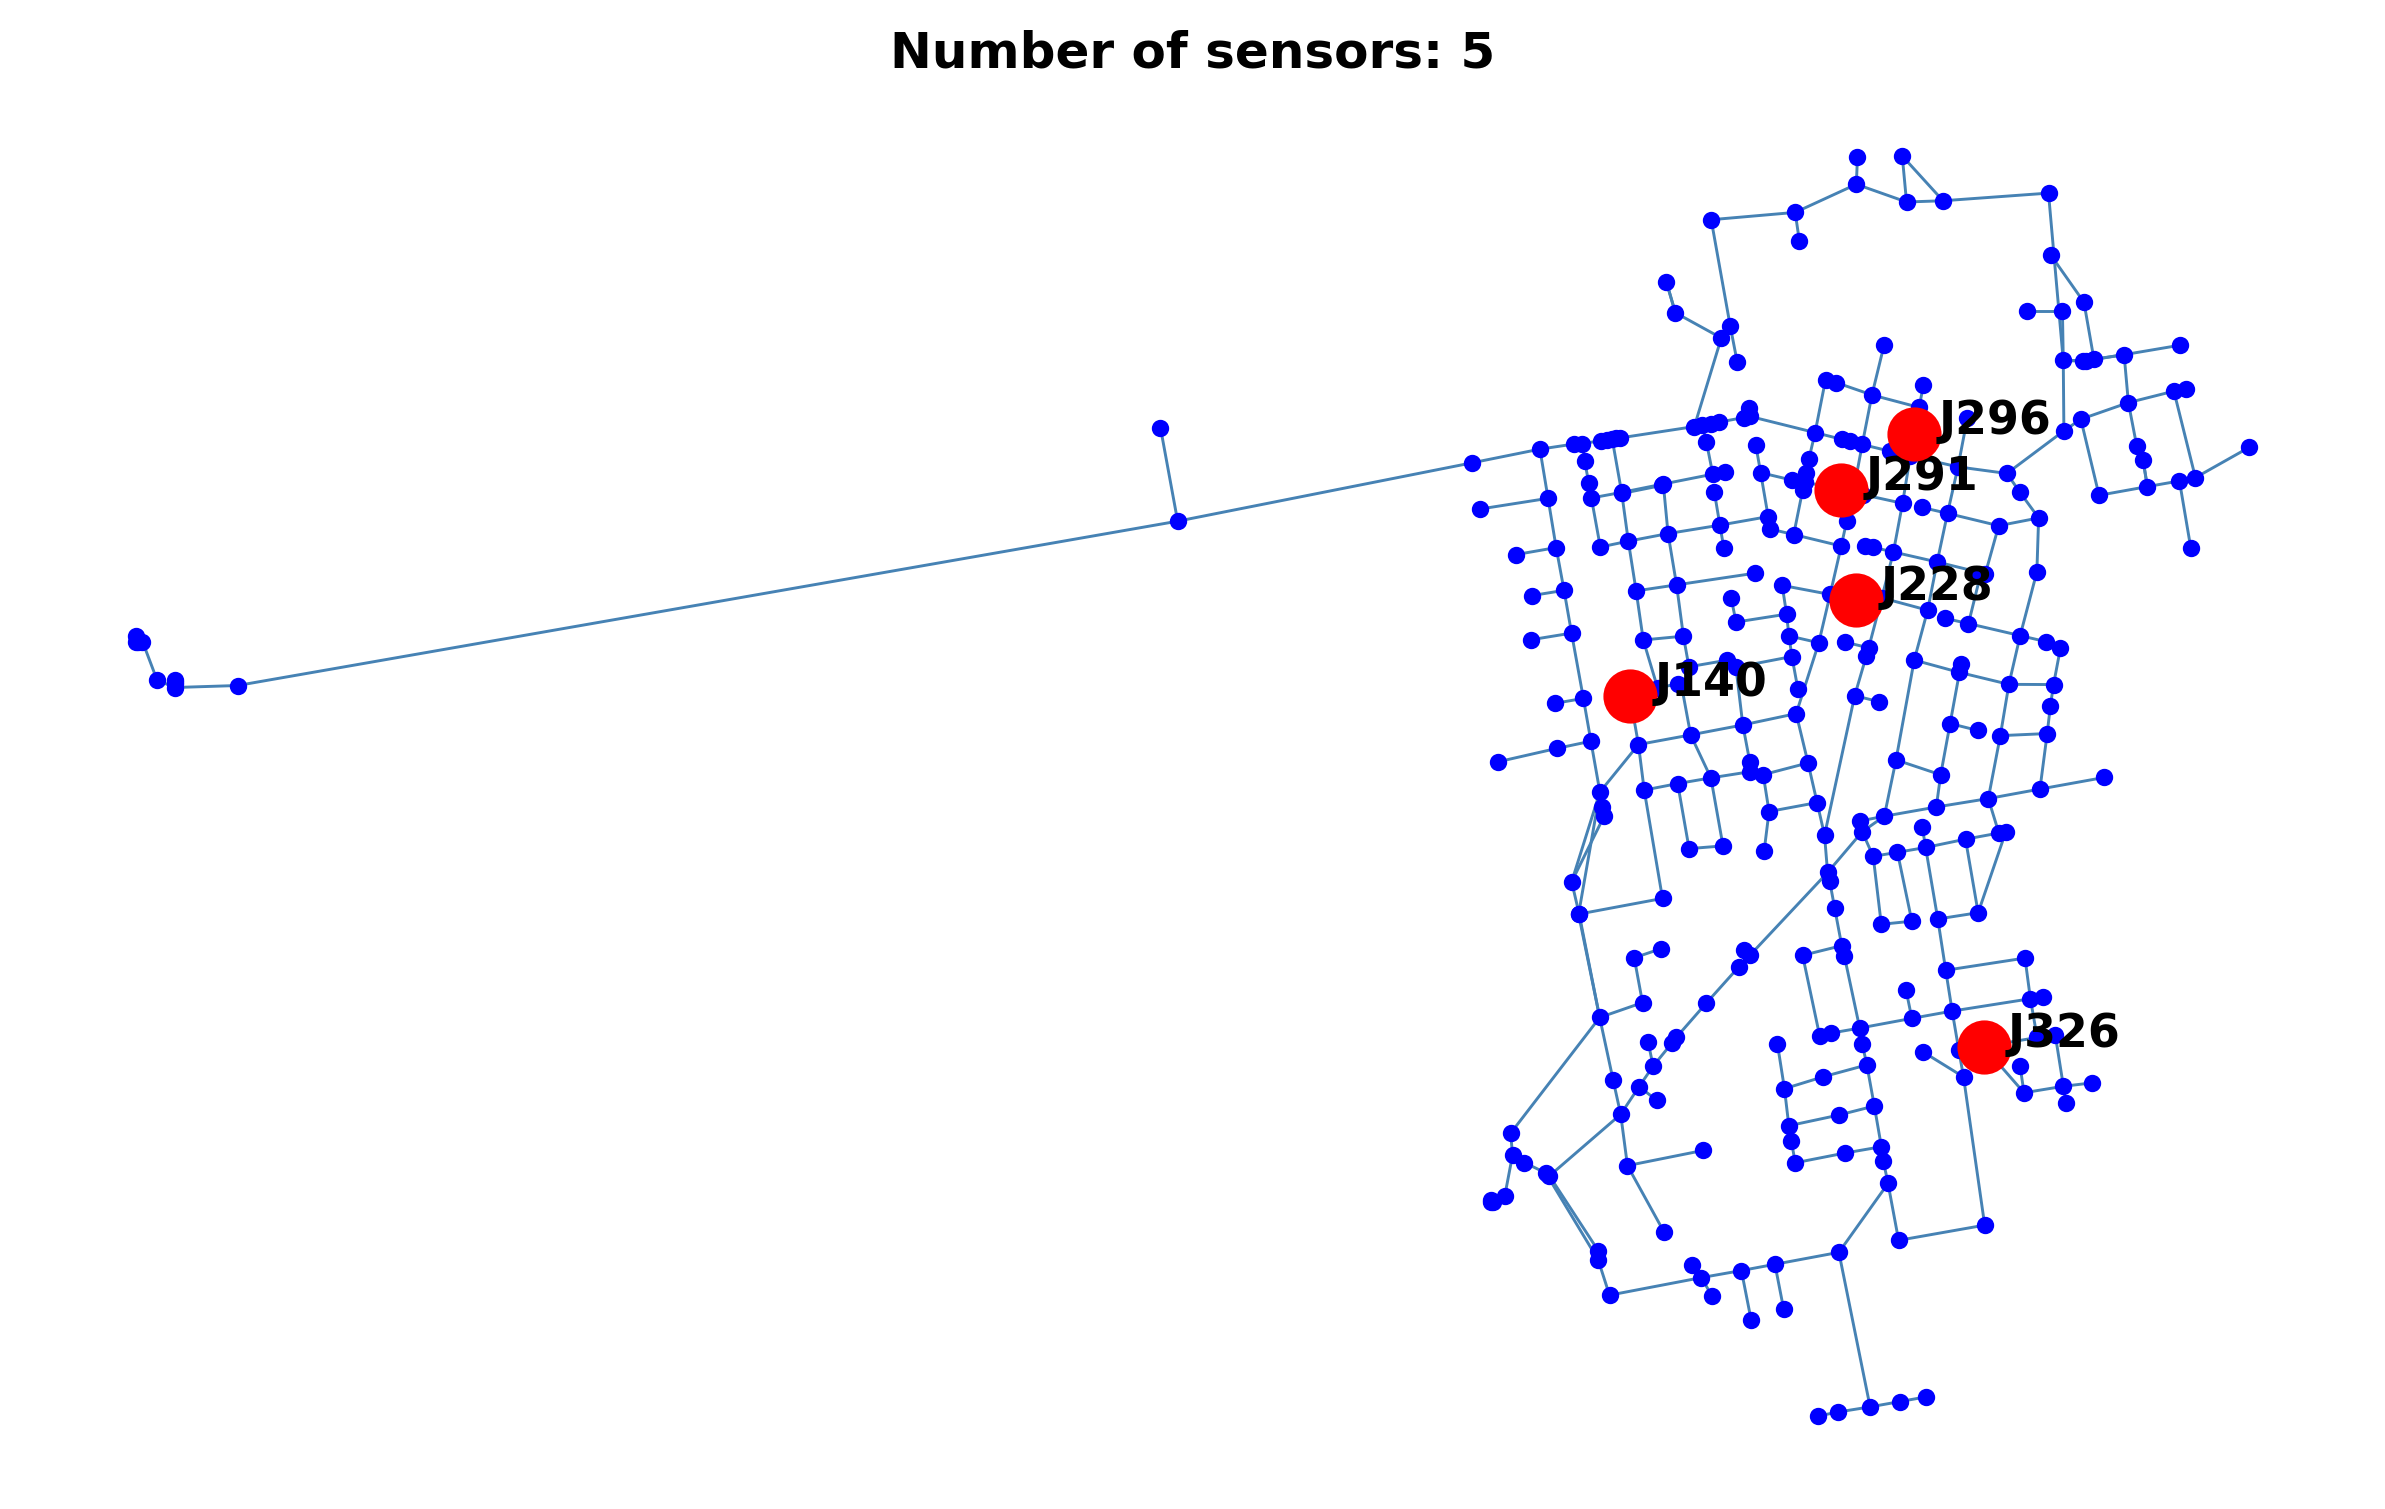

In [42]:
# Get indices of top sensors
top_sensors_indices = np.argsort(u)[-sensors_num:][::-1]

print(top_sensors_indices)
senors_ids = d.getNodeNameID(list(top_sensors_indices + 1))
# print("Indices of top", sensors_num, "selected sensors:", senors_ids)

# Load optimal solution (for demonstration only!)
sens_IDs_demonstration = senors_ids
sens_ind = d.getNodeIndex(sens_IDs_demonstration)
print(senors_ids)
print(sens_IDs_demonstration)

def custom_plot(coor):
    x_nodes = list(coor['x'].values())
    y_nodes = list(coor['y'].values())
    # Get links connecting nodes
    links = d.getNodesConnectingLinksIndex()
    # Plot the network manually
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    for link in links:
        x_coords = [coor['x'][link[0]], coor['x'][link[1]]]
        y_coords = [coor['y'][link[0]], coor['y'][link[1]]]
        ax.plot(x_coords, y_coords, color='steelblue', linewidth=0.7)
    ax.axis('off')
    # Plot nodes
    ax.scatter(x_nodes, y_nodes, color='blue', s=10, zorder=5)
    return ax


# Get node coordinates
coor = d.getNodeCoordinates()
# Custom plot - network plot
ax = custom_plot(coor)

# Plot sensors on the network
for sens in sens_ind:
    # Add plot point for the leak node
    x_sens = coor['x'][sens]
    y_sens = coor['y'][sens]

    sens_id = d.getNodeNameID(sens)
    # Plot the sens node with a higher zorder
    ax.plot(x_sens, y_sens, 'o', color='r', markersize=12, zorder=10)
    ax.text(x_sens + 60, y_sens, sens_id, color='black', fontweight='bold', fontsize=11, zorder=10)

# Set the title and show the plot
ax.set_title(f'Number of sensors: {len(sens_ind)}', fontweight='bold')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
